# Import packages & functions

In [1]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils

import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
spec.loader.exec_module(preproc)

# Can run a SLURM job array to train many models with different random seed values
try:
    seed = int(os.environ["SLURM_ARRAY_TASK_ID"])
    print(f"using random seed {seed} in SLURM job {seed} of array")
except:
    print("SLURM random seed indices not provided; using random seed = 0")
    seed = 0

if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

importing modules
SLURM random seed indices not provided; using random seed = 0


# Princeton data prep

## Load Data & Design

In [2]:
sub = 'sub-005'
session = 'all'
task='task-C_'  # '' (empty string) normally, task-A_ or similar otherwise
func_task_name = 'C'  # 'study' or 'A'; used to search for functional run in bids format
resample_voxel_size = False

# settings for multiple sessions
if session == "all":
    ses_list = ["ses-01", "ses-02"]  # list of actual session IDs
    design_ses_list = ["ses-01", "ses-02"]  # list of session IDs to search for design matrix
else:
    ses_list = [session]
    design_ses_list = [session]
    
multi_session = False  # do you want to run GLMsingle on multiple sessions for this subject? 
ref_session = None  # None or 'ses-xx'; use the T1 from the reference session; use this only if the current session doesn't have a T1
if ref_session is not None: 
    assert multi_session is True
if ref_session is None: ref_session = session

if sub=='sub-001' and session == 'ses-01':
    n_runs=16
elif sub=='sub-002' and session == 'ses-01':
    n_runs=9
elif (sub=='sub-001' and session in ('ses-05')) or (sub=='sub-002' and session in ('ses-02')) or (sub=='sub-004' and session in ('ses-01')):
    n_runs=5
elif sub=='sub-004' and session  == 'ses-02':
    n_runs = 12
elif sub=='sub-004' and session == 'all':
    n_runs = 17
    runs_per_session = {
    "ses-01": 5,
    "ses-02": 12
    }
elif sub=='sub-005' and session in ('ses-01', 'ses-02', 'ses-03'):
    n_runs=11
elif sub=='sub-005' and session == 'all':
    n_runs=22
    runs_per_session = {
    "ses-01": 11,
    "ses-02": 11
    #, "ses-03": 11
    }
else:
    raise Exception("undefined subject and/or session")
runs_per_session = {session: n_runs} if not multi_session else runs_per_session
if multi_session: assert runs_per_session is not None
print(n_runs, "functional runs")
train_test_split = 'MST' # 'orig'
remove_close_to_MST = False
remove_random_n = False
# if remove_close_to_MST or remove_random_n:
#     assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

# if remove_random_n:
#     assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
#     n_to_remove = 150

22 functional runs


In [3]:
session_label = preproc.get_session_label(ses_list)

In [4]:
glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{session_label}_task-{func_task_name}"
print(glmsingle_path)
assert os.path.exists(glmsingle_path)
designdir = "/home/ri4541/real_time_mindEye2"

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01-02_task-C


In [5]:
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = preproc.load_design_files(
    sub=sub,
    session=session,
    func_task_name=func_task_name,
    designdir=designdir,
    design_ses_list=design_ses_list
)

# assert len(images[images!="blank.jpg"]) == 1008
# assert len(np.unique(images[images!="blank.jpg"])) == 708
if remove_random_n:
    # want to remove 150 imgs
    # 100 special515 imgs are repeated 3x (300 total)
    # all other train imgs are only shown once (558 total)
    # of the 150, want to sample proportionally since we're cutting all repeats for special515
    # so take out 51 (17 unique) from special515 and 99 from rest = removing 150 total
    np.random.seed(seed)
    options_to_remove = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' not in x and list(image_names).count(x)==1]  # all the imgs that only appear once (this is O(N^2) b/c of count() within list comprehension but image_names is a relatively small list)
    options_to_remove_special515 = [x for x in set(image_names) if str(x) != 'nan' and x != 'blank.jpg' and 'MST_pairs' not in x and 'special515' in x and list(image_names).count(x)>1]  # all the special515 images that are repeated (count()>1 necessary because there are special515 that are not repeated)
    imgs_to_remove = np.random.choice(options_to_remove, size=99, replace=False)
    imgs_to_remove = np.append(imgs_to_remove, np.random.choice(options_to_remove_special515, size=17, replace=False))

image_idx = np.array([])  # contains the unique index of each presented image
vox_image_names = np.array([])  # contains the names of the images corresponding to image_idx
all_MST_images = dict()
for i, im in enumerate(image_names):
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    vox_image_names = np.append(vox_image_names, im)
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            i+=1
            continue
    elif remove_random_n:
        if im in imgs_to_remove:
            i+=1
            continue
            
    image_idx_ = np.where(im==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
    
    if sub == 'ses-01' and session in ('ses-01', 'ses-04'):  # MST images are ones that matched these image titles
        import re
        if ('w_' in im or 'paired_image_' in im or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', im) or re.match(r'images/\d{1,2}_\d{1,3}\.png$', im)):  
        # the regexp here looks for **_***.png, allows 1-2 chars before underscore and 1-3 chars after it
            # print(im)
            all_MST_images[i] = im
            i+=1            
    elif 'MST' in im:
        all_MST_images[i] = im
        i+=1
    
image_idx = torch.Tensor(image_idx).long()
# for im in new_image_names[MST_images]:
#     assert 'MST_pairs' in im
# assert len(all_MST_images) == 300

unique_MST_images = np.unique(list(all_MST_images.values())) 

MST_ID = np.array([], dtype=int)
if remove_close_to_MST:
    close_to_MST_idx = np.array([], dtype=int)
if remove_random_n:
    random_n_idx = np.array([], dtype=int)

vox_idx = np.array([], dtype=int)
j=0  # this is a counter keeping track of the remove_random_n used later to index vox based on the removed images; unused otherwise
for i, im in enumerate(image_names):  # need unique_MST_images to be defined, so repeating the same loop structure
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    if remove_close_to_MST:  # optionally skip close_to_MST images 
        if "closest_pairs" in im:
            close_to_MST_idx = np.append(close_to_MST_idx, i)
            i+=1
            continue
    if remove_random_n:
        if im in imgs_to_remove:
            vox_idx = np.append(vox_idx, j)
            i+=1
            j+=1
            continue
    j+=1
    curr = np.where(im == unique_MST_images)
    # print(curr)
    if curr[0].size == 0:
        MST_ID = np.append(MST_ID, np.array(len(unique_MST_images)))  # add a value that should be out of range based on the for loop, will index it out later
    else:
        MST_ID = np.append(MST_ID, curr)
        
assert len(MST_ID) == len(image_idx)
# assert len(np.argwhere(pd.isna(data['current_image']))) + len(np.argwhere(data['current_image'] == 'blank.jpg')) + len(image_idx) == len(data)
# MST_ID = torch.tensor(MST_ID[MST_ID != len(unique_MST_images)], dtype=torch.uint8)  # torch.tensor (lowercase) allows dtype kwarg, Tensor (uppercase) is an alias for torch.FloatTensor
print(MST_ID.shape)
if session in ('ses-01', 'ses-04'):
    assert len(all_MST_images) == 100

Loading: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Loading: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-02.csv
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-02.csv
Total number of images: 1540
Number of unique images: 1001
(1386,)


## Load images

In [6]:
import imageio.v2 as imageio
resize_transform = transforms.Resize((224, 224))
MST_images = []
images = None
for im_name in tqdm(image_idx):
    if session == 'ses-01':
        image_file = f"all_stimuli/rtmindeye_stimuli/{unique_images[im_name]}"
    else:
        image_file = f"{unique_images[im_name]}"
    im = imageio.imread(image_file)
    im = torch.Tensor(im / 255).permute(2,0,1)
    im = resize_transform(im.unsqueeze(0))
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    if sub == 'ses-01' and session in ('ses-01', 'ses-04'):
        if ('w_' in image_file or 'paired_image_' in image_file or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', image_file) or re.match(r'all_stimuli/rtmindeye_stimuli/images/\d{1,2}_\d{1,3}\.png$', image_file)):  
            MST_images.append(True)
        else:
            MST_images.append(False)
    else:   
        if ("MST_pairs" in image_file): # ("_seed_" not in unique_images[im_name]) and (unique_images[im_name] != "blank.jpg") 
            MST_images.append(True)
        else:
            MST_images.append(False)

print("images", images.shape)
MST_images = np.array(MST_images)
print("MST_images", len(MST_images))
if session in ('ses-01', 'ses-04'):
    assert len(MST_images[MST_images==True]) == 100
print("MST_images==True", len(MST_images[MST_images==True]))

  0%|          | 0/1386 [00:00<?, ?it/s]/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1386/1386 [01:32<00:00, 14.96it/s]

images torch.Size([1386, 3, 224, 224])
MST_images 1386
MST_images==True 248


In [18]:
# unique_images_pairs = [
#     (1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16),
#     (17,18),(19,20),(21,22),(23,24),(25,26),(27,28),(29,30),
#     (31,32),(33,34),(35,36),
#     (787, 788), (789, 790), (791, 792), (793, 794), (795, 796),
#     (797, 798), (799, 800), (801, 802), (803, 804), (805, 806),
#     (807, 808), (809, 810), (811, 812), (813, 814), (815, 816),
#     (817, 818), (819, 820), (821, 822), (823, 824), (825, 826),
#     (827, 828), (829, 830), (831, 832), (833, 834), (835, 836),
#     (837, 838), (839, 840), (841, 842), (843, 844), (845, 846),
#     (847, 848), (849, 850)
# ]
# unique_images[unique_images_pairs]

In [49]:
unique_MST_images

array(['all_stimuli/MST_pairs1/pair_0_1_22.png',
       'all_stimuli/MST_pairs1/pair_0_1_78.png',
       'all_stimuli/MST_pairs1/pair_10_14_33.png',
       'all_stimuli/MST_pairs1/pair_10_14_89.png',
       'all_stimuli/MST_pairs1/pair_12_16_22.png',
       'all_stimuli/MST_pairs1/pair_12_16_78.png',
       'all_stimuli/MST_pairs1/pair_14_18_22.png',
       'all_stimuli/MST_pairs1/pair_14_18_78.png',
       'all_stimuli/MST_pairs1/pair_16_20_0.png',
       'all_stimuli/MST_pairs1/pair_16_20_56.png',
       'all_stimuli/MST_pairs1/pair_18_nsd_6_1_cocoid_13417.png',
       'all_stimuli/MST_pairs1/pair_18_nsd_6_2_cocoid_24103.png',
       'all_stimuli/MST_pairs1/pair_20_nsd_41_1_cocoid_15472.png',
       'all_stimuli/MST_pairs1/pair_20_nsd_41_2_cocoid_63715.png',
       'all_stimuli/MST_pairs1/pair_22_nsd_115_1_cocoid_8171.png',
       'all_stimuli/MST_pairs1/pair_22_nsd_115_2_cocoid_65194.png',
       'all_stimuli/MST_pairs1/pair_24_nsd_158_1_cocoid_2285.png',
       'all_stimuli/MST_pai

In [48]:
# want IDs of pairmates based on MST_images
# create "MST_pairmates" which is a 25x2 array with indices of the 25 pairs based on MST_images == True

assert unique_MST_images.shape[0] % 2 == 0  # make sure it's divisible by 2
MST_pairmate_names = unique_MST_images.reshape(int(unique_MST_images.shape[0]/2),2)
# print(MST_pairmate_names[:5])

MST_pairmate_indices = np.empty(shape=MST_pairmate_names.shape, dtype=int)
for p, pair in enumerate(MST_pairmate_names):
    for i, im in enumerate(pair):
        MST_pairmate_indices[p][i] = np.where(np.isin(list(all_MST_images.values()), im))[0][0]  # just take the first repeated instance of an image
        
# print(MST_pairmate_indices, MST_pairmate_indices.shape)

AssertionError: 

In [8]:
if session in ('ses-02', 'ses-03', 'all'):
    # MST_pairs contains the indices of repeats based on all_MST_images
    # all_MST_images contains the indices of images from image_names
    MST_pairs = utils.find_paired_indices(torch.tensor(MST_ID))
    MST_pairs = np.array(sorted(MST_pairs[:-1], key=lambda x: x[0]))  # we added a fake value as a placeholder so index out the last group of pairs

    # assert images[MST_pairs]

    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    fig.suptitle('Sample MST pairs')

    ax[0].imshow(images[MST_pairs[-1][0]].permute(1,2,0).numpy())
    ax[0].set_title(f"Trial 0")

    ax[1].imshow(images[MST_pairs[-1][1]].permute(1,2,0).numpy())
    ax[1].set_title(f"Trial 1")

    ax[2].imshow(images[MST_pairs[-1][2]].permute(1,2,0).numpy())
    ax[2].set_title(f"Trial 2")

    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()

In [35]:
# pairs has the indices of all repeated images
pairs = utils.find_paired_indices(image_idx)
pairs = list(sorted(pairs, key=lambda x: x[0]))

plt.figure(figsize=(2,2))
plt.imshow(images[0].permute(1,2,0).numpy())
plt.title(f"Trial 0")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(images[1].permute(1,2,0).numpy())
plt.title(f"Trial 1")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(images[2].permute(1,2,0).numpy())
plt.title(f"Trial 2")
plt.show()

p=100
if session in ('ses-02', 'ses-03', 'all'):
    fig, ax = plt.subplots(1, 3, figsize=(10,8))

    ax[0].imshow(images[pairs[p][0]].permute(1,2,0).numpy())
    ax[0].set_title(f"Repeat 1")

    ax[1].imshow(images[pairs[p][1]].permute(1,2,0).numpy())
    ax[1].set_title(f"Repeat 2")

    ax[2].imshow(images[pairs[p][2]].permute(1,2,0).numpy())
    ax[2].set_title(f"Repeat 3")

    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()
    
else:
    fig, ax = plt.subplots(1, 2, figsize=(10,8))

    ax[0].imshow(images[pairs[p][0]].permute(1,2,0).numpy())
    ax[0].set_title(f"Repeat 1")

    ax[1].imshow(images[pairs[p][1]].permute(1,2,0).numpy())
    ax[1].set_title(f"Repeat 2")

    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()

AttributeError: 'str' object has no attribute 'permute'

<Figure size 200x200 with 0 Axes>

## Load GLMSingle voxel data

In [30]:
path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses_list[0]}_task-{func_task_name}/TYPED_FITHRF_GLMDENOISE_RR.npz"
print(path)
os.path.exists(path)

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-004_ses-01_task-C/TYPED_FITHRF_GLMDENOISE_RR.npz


True

In [61]:
print(func_masks[0].affine, '\n', func_masks[1].affine)
print(func_masks[0].shape, func_masks[1].shape)

[[  2.           0.           0.         -70.92371368]
 [  0.           2.           0.         -88.12161255]
 [  0.           0.           2.         -51.61133194]
 [  0.           0.           0.           1.        ]] 
 [[  2.           0.           0.         -70.92371368]
 [  0.           2.           0.         -88.12161255]
 [  0.           0.           2.         -51.61133194]
 [  0.           0.           0.           1.        ]]
(73, 91, 71) (73, 91, 71)


In [98]:
func_masks[0].get_fdata().sum(), avg_mask.get_fdata().sum()

(170922.0, 159156.0)

In [96]:
vox[:,0,0].shape

(315, 170922)

In [95]:
tmp = nilearn.masking.unmask(vox[:,0,0], avg_mask)
tmp.get_fdata().shape

TypeError: X must be of shape (samples, 159156).

In [94]:
avg_mask.affine

array([[  2.        ,   0.        ,   0.        , -70.92371368],
       [  0.        ,   2.        ,   0.        , -88.12161255],
       [  0.        ,   0.        ,   2.        , -51.61133194],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [86]:
tmp2.shape

(73, 91, 71)

In [91]:
tmp = nilearn.masking.unmask(vox[:,0,0], avg_mask)
tmp2 = nib.Nifti1Image(np.mean(tmp.get_fdata(), axis=-1), avg_mask.affine)
plot_roi(tmp2, bg_img=avg_mask)

TypeError: X must be of shape (samples, 159156).

In [8]:
def get_betas(path):
    glmsingle = np.load(path, allow_pickle=True) 
    return glmsingle['betasmd'].T

In [9]:
if session == "all":
    vox_list = []
    for s in ses_list:
        path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{s}_task-{func_task_name}/TYPED_FITHRF_GLMDENOISE_RR.npz"
        vox_list.append(get_betas(path))
        print(f"Loaded session: {s} | Current shape: {vox_list[-1].shape}")

    vox = np.concatenate(vox_list)

else:
    vox = get_betas(f"{glmsingle_path}/TYPED_FITHRF_GLMDENOISE_RR.npz")
    
print("vox", vox.shape)

if vox.ndim==4:
    vox = vox[:,0,0]
    print("vox", vox.shape)
    
if remove_close_to_MST:
    x = [x for x in image_names if (x!='blank.jpg') and (str(x)!='nan')]
    close_to_MST_idx = [y for y,z in enumerate(x) if 'closest_pairs' in z]
    # len(x), len(close_to_MST_idx)
    close_to_MST_mask = np.ones(len(vox), dtype=bool)
    close_to_MST_mask[close_to_MST_idx] = False
    vox = vox[close_to_MST_mask]
    print("vox after removing close_to_MST", vox.shape)
elif remove_random_n:
    random_n_mask = np.ones(len(vox), dtype=bool)
    random_n_mask[vox_idx] = False
    vox = vox[random_n_mask]
    print(f"vox after removing {n_to_remove}", vox.shape)

    
assert len(vox) == len(image_idx)

Loaded session: ses-01 | Current shape: (693, 1, 1, 182259)
Loaded session: ses-02 | Current shape: (693, 1, 1, 183159)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 3, the array at index 0 has size 182259 and the array at index 1 has size 183159

### Load nsdgeneral ROI

creating multisession brain mask
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-004_ses-01_task-C/sub-004_ses-01_task-C_brain.nii.gz
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-004_ses-02_task-C/sub-004_ses-02_task-C_brain.nii.gz
Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -70.92371368]
 [  0.           2.           0.         -88.12161255]
 [  0.           0.           2.         -51.61133194]
 [  0.           0.           0.           1.        ]]

There are 159156 voxels in the included brain mask

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-004_ses-01_task-C/sub-004_ses-01_task-C_nsdgeneral.nii.gz
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-004_ses-02_task-C/sub-004_ses-02_task-C_nsdgeneral.nii.gz


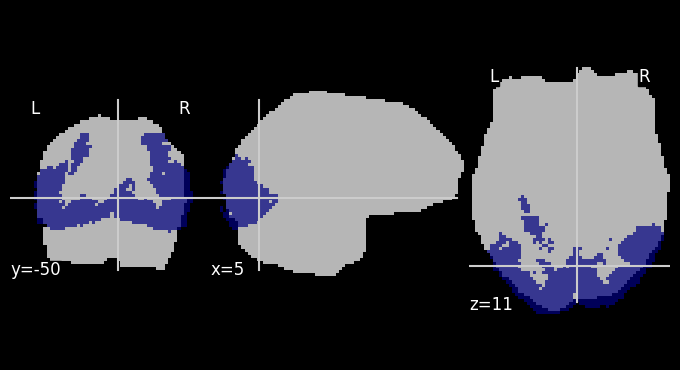

In [6]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi
from nilearn.masking import intersect_masks
import nilearn

# avg_mask=nib.load(f'{sub}_ses-01_brain.nii.gz')
if session == "all":
    print('creating multisession brain mask')
    mask_imgs = []
    for ses in ses_list:
        mask_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses}_task-{func_task_name}/{sub}_{ses}_task-{func_task_name}_brain.nii.gz"

        print(mask_path)
        assert os.path.exists(mask_path)
        mask_imgs.append(mask_path)

    func_masks = [nilearn.image.load_img(mask) for mask in mask_imgs]
    avg_mask = intersect_masks(func_masks, threshold=0.5, connected=True)

    # avg_mask=nib.load(f'{glmsingle_path}/{sub}_brain_multi.nii.gz')
else:
    print('loading single session brain mask')
    avg_mask=nib.load(f'{glmsingle_path}/{sub}_{session}_brain.nii.gz')
    # avg_mask=nib.load(f'masks/{sub}_{session}_brain.nii.gz')

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

nsd_masks = []
for ses in ses_list:
    mask_name = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses}_task-{func_task_name}/{sub}_{ses}_task-{func_task_name}_nsdgeneral.nii.gz"
    print(mask_name)
    assert os.path.exists(mask_name)
    nsd_masks.append(mask_name)

nsd_masks = [nilearn.image.load_img(mask) for mask in nsd_masks]
roi = intersect_masks(nsd_masks, threshold=0.5, connected=True)

plot_roi(roi, bg_img=avg_mask)
plt.show()

In [7]:
avg_mask = avg_mask.get_fdata().flatten()
print(f"total voxels (whole brain) = {int(avg_mask.sum())}")

roi = roi.get_fdata()
roi = roi.flatten()
roi = roi[avg_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")

total voxels (whole brain) = 159156
nsdgeneral voxels = 17536


### ROI voxel exclusion

In [8]:
roi.shape[0], int(avg_mask.sum()), avg_mask.shape, vox.shape[-1]

NameError: name 'vox' is not defined

In [21]:
# ROI masking?
print(f"vox before ROI exclusion: {vox.shape}")
# vox = vox[:,roi]
vox[:, ~roi] = 0
print(f"vox after ROI exclusion: {vox.shape}")

if np.any(np.isnan(vox)):
    print("NaNs found! Removing voxels...")
    x,y = np.where(np.isnan(vox))
    vox = vox[:,np.setdiff1d(np.arange(vox.shape[-1]), y)]

vox before ROI exclusion: (630, 170922)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 170922 but corresponding boolean dimension is 159156

## Reliability calculation

### Calculate reliability (corr between first and second presentation of same image) for every voxel

In [42]:
from copy import deepcopy
pairs_orig = pairs
pairs = np.array([[pair[0], pair[1]] for pair in pairs])

In [47]:
pairs_orig

[[1, 151],
 [4, 57, 358],
 [24, 104],
 [25, 329],
 [26, 168],
 [28, 437, 440],
 [40, 387, 413],
 [43, 169],
 [48, 351],
 [51, 759],
 [52, 239],
 [56, 291],
 [59, 333, 548],
 [67, 660],
 [69, 672],
 [73, 346],
 [82, 518, 567],
 [87, 353, 603],
 [89, 633],
 [90, 556, 811],
 [92, 629, 701],
 [101, 423],
 [113, 599],
 [115, 749],
 [120, 495, 508],
 [121, 550],
 [141, 459],
 [143, 670],
 [144, 148, 152],
 [154, 362, 814],
 [156, 391],
 [158, 761],
 [178, 578],
 [179, 331],
 [187, 588],
 [191, 527],
 [200, 625, 630],
 [201, 206],
 [205, 694],
 [213, 396],
 [221, 775, 807],
 [227, 318],
 [230, 375],
 [234, 444],
 [235, 679],
 [244, 463],
 [256, 412],
 [259, 687],
 [281, 804],
 [290, 293, 336],
 [303, 744],
 [305, 738],
 [308, 369, 439],
 [311, 454, 699],
 [314, 800],
 [315, 487],
 [320, 434, 479],
 [340, 607],
 [350, 380],
 [365, 676],
 [388, 424, 540],
 [405, 537],
 [414, 621],
 [438, 501, 543],
 [453, 702, 743],
 [458, 627, 698],
 [474, 757],
 [477, 579],
 [478, 785],
 [481, 541],
 [504, 68

In [43]:
vox_pairs = utils.zscore(vox[pairs])
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]
print("rels", rels.shape)
assert np.sum(np.all(np.isnan(rels))) == 0

IndexError: index 759 is out of bounds for axis 0 with size 630

### Create representational similarity matrix

In [15]:
# creating img x vox x repetitions matrix | shape=(150, 18419, 2)
vox0 = np.zeros((len(pairs), vox.shape[-1], 2))
for ipair, pair in enumerate(tqdm(pairs)):
    pair = pair[:2] # to keep things consistent, just using the first two repeats
    i,j = pair
    vox0[ipair, :, :] = vox[pair].T
vox_avg = vox0.mean(-1) # average across the repetitions

100%|██████████| 150/150 [00:00<00:00, 388.17it/s]


In [16]:
# Masking RDM for each reliability threshold
r_thresholds = np.array([.0, .1, .2, .3])
rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) 
for ir_thresh, r_thresh in enumerate(r_thresholds):
    print(f"reliability threshold = {r_thresh}")
    for i in tqdm(range(len(pairs))):
        for j in range(len(pairs)):
            rdm[ir_thresh,i,j] = np.corrcoef(vox_avg[i,rels>r_thresh], 
                                             vox_avg[j,rels>r_thresh])[0,1]
# rdm is shape (4, 150, 150)

reliability threshold = 0.0


100%|██████████| 150/150 [01:01<00:00,  2.42it/s]


reliability threshold = 0.1


100%|██████████| 150/150 [00:30<00:00,  4.99it/s]


reliability threshold = 0.2


100%|██████████| 150/150 [00:21<00:00,  6.89it/s]


reliability threshold = 0.3


100%|██████████| 150/150 [00:19<00:00,  7.51it/s]


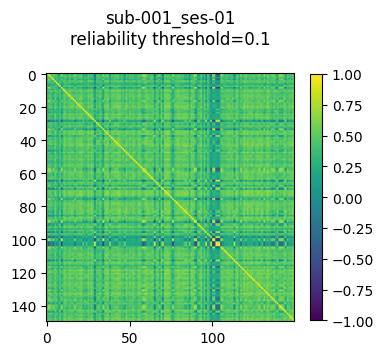

In [17]:
reliability_threshold_to_visualize = .1
plt.figure(figsize=(4,4))
plt.imshow(rdm[np.where(r_thresholds==reliability_threshold_to_visualize)[0].item()], clim=(-1,1))
plt.colorbar(shrink=0.8)
plt.title(f"{sub}_{session}\nreliability threshold={reliability_threshold_to_visualize}\n")
plt.show()

In [18]:
for thresh in range(rdm.shape[0]):
    for img in range(rdm.shape[1]):
        assert np.isclose(rdm[thresh, img, img], 1)

In [19]:
# Reliability thresholding?
print(f"\nvox before reliability thresholding: {vox.shape}")
vox = vox[:,rels>.2]
print(f"\nvox after reliability thresholding: {vox.shape}")


vox before reliability thresholding: (1000, 165240)

vox after reliability thresholding: (1000, 165240)


In [20]:
print(images.shape)
print(vox.shape)
assert len(images) == len(vox)

torch.Size([1000, 3, 224, 224])
(1000, 165240)


150 150


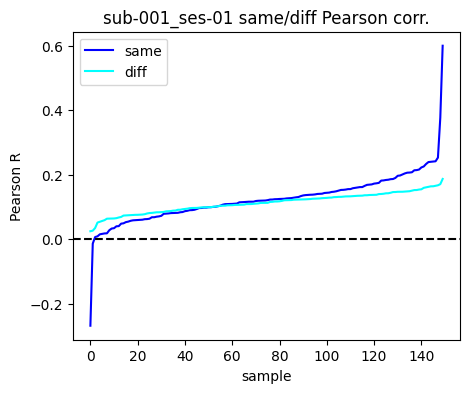

In [21]:
same_corrs = []
diff_corrs = []
for isamp, samp in enumerate(vox[pairs]):
    avg_same_img = []
    for i in range(samp.shape[0]):
        for j in range(i, samp.shape[0]):
            if i != j:
                avg_same_img.append(np.array([np.corrcoef(samp[i, :], samp[j, :])[0,1]]))
    
    same_corrs.append(np.mean(avg_same_img))
                       
    avg_diff_img = []
    for isamp_j, samp_j in enumerate(vox[pairs]):
        if isamp_j != isamp:
            for i in range(samp_j.shape[0]):
                for j in range(i, samp_j.shape[0]):
                    if i != j:
                        avg_diff_img.append(np.array([np.corrcoef(samp[i, :], samp_j[j, :])[0,1]]))
                                    
    # print(len(avg_diff_img))
    diff_corrs.append(np.mean(avg_diff_img))


print(len(same_corrs), len(diff_corrs))
same_corrs = np.array(same_corrs)
diff_corrs = np.array(diff_corrs)


plt.figure(figsize=(5,4))
plt.title(f"{sub}_{session} same/diff Pearson corr.")
plt.plot(np.sort(same_corrs),c='blue',label='same')
plt.plot(np.sort(diff_corrs),c='cyan',label='diff')
plt.axhline(0,c='k',ls='--')
plt.legend()
plt.xlabel("sample")
plt.ylabel("Pearson R")
plt.show()

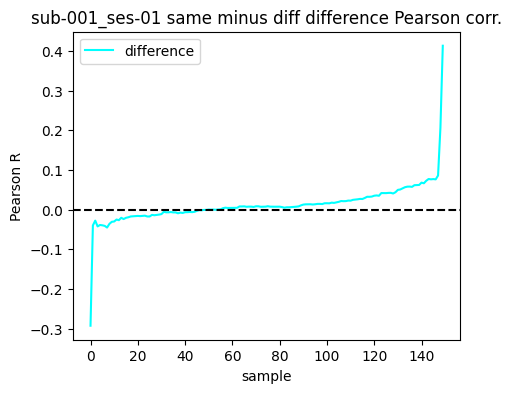

In [22]:
vox_pairs = utils.zscore(vox[pairs])
plt.figure(figsize=(5,4))
plt.title(f"{sub}_{session} same minus diff difference Pearson corr.")
plt.plot(np.sort(same_corrs) - np.sort(diff_corrs),c='cyan',label='difference')
plt.axhline(0,c='k',ls='--')
plt.legend()
plt.xlabel("sample")
plt.ylabel("Pearson R")
plt.show()

## does on/off r2 correlate with final reliability estimates?

In [23]:
def np2nib(data, mask):
    data_3d = np.zeros(mask.get_fdata().shape)  # shape includes voxels outside the brain
    data_3d[mask.get_fdata()!=0] = data  # fill the nonzero values (the ones in the brain) with the data; filter voxels that are in the brain
    return nib.Nifti1Image(data_3d, mask.affine)  # convert to nibabel object and return

In [24]:
# on_off['onoffR2'].shape, rels.shape, avg_mask.shape

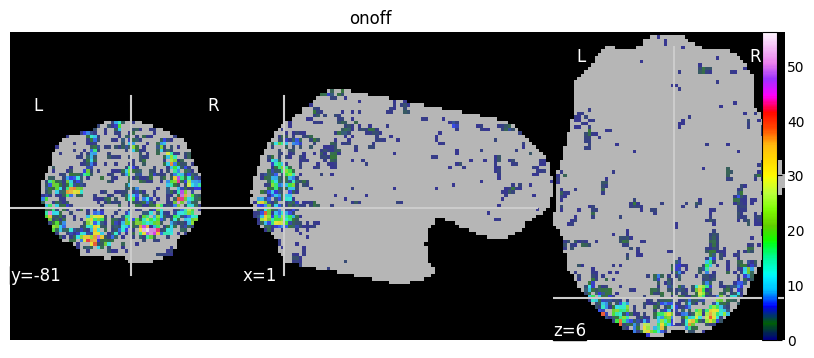

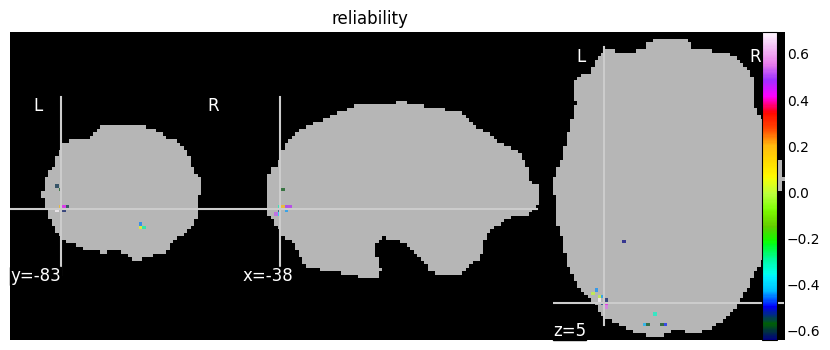

In [25]:
# load on/off r2 and convert to nifti image using avg_mask affine
on_off = np.load(f'{glmsingle_path}/TYPEA_ONOFF.npz', allow_pickle=True)
avg_mask=nib.load(f'{glmsingle_path}/{sub}_{session}_brain.nii.gz')

onoff_nib = np2nib(on_off['onoffR2'], avg_mask)
# onoff_nib = np2nib(utils.zscore(on_off['onoffR2']), avg_mask)

# get reliability mask from above
rels_nib = np2nib(rels, avg_mask)
# rels_nib = np2nib(utils.zscore(rels), avg_mask)

# confirm they're both in the same space

# plot both 
fig,ax=plt.subplots(1,1, figsize=(10,4))
d1 = plot_roi(onoff_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=onoff_nib.get_fdata().min(), vmax=onoff_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('onoff')
plt.show()

fig,ax=plt.subplots(1,1, figsize=(10,4))
d2 = plot_roi(rels_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=rels_nib.get_fdata().min(), vmax=rels_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('reliability')
plt.show()

In [26]:
rels_nib.get_fdata().shape

(72, 94, 71)

In [27]:
np.where(rels_nib.get_fdata()!=0)[0]

array([ 3,  3,  3, ..., 69, 69, 69])

In [28]:
on_off

NpzFile '/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/TYPEA_ONOFF.npz' with keys: onoffR2, meanvol, betasmd

In [29]:
np.corrcoef(onoff_nib.get_fdata().flatten(), rels_nib.get_fdata().flatten())[0,1]

0.3703298672128314

In [30]:
print(f"onoff range: ({on_off['onoffR2'].min():.3f}, {on_off['onoffR2'].max():.3f})")
print(f"rels range: ({rels.min():.3f}, {rels.max():.3f})")

onoff range: (-0.000, 56.189)
rels range: (-0.643, 0.694)


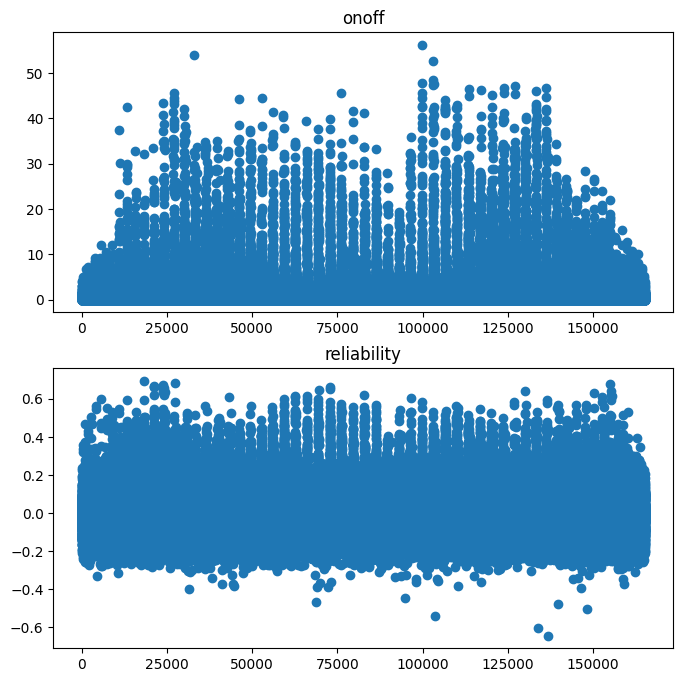

In [31]:
fig,ax = plt.subplots(2,1, figsize=(8,8))
ax[0].scatter(np.arange(len(on_off['onoffR2'])), on_off['onoffR2'])
ax[0].set_title('onoff')
ax[1].scatter(np.arange(len(rels)),rels)
ax[1].set_title('reliability')

plt.show()

In [32]:
glmsingle = np.load(f"{glmsingle_path}/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) 
vox = glmsingle['betasmd'].T
vox.shape

(1000, 165240)

## Is there an on/off r^2 threshold that isolates the majority of reliable voxels?

(165240,) (165240,)


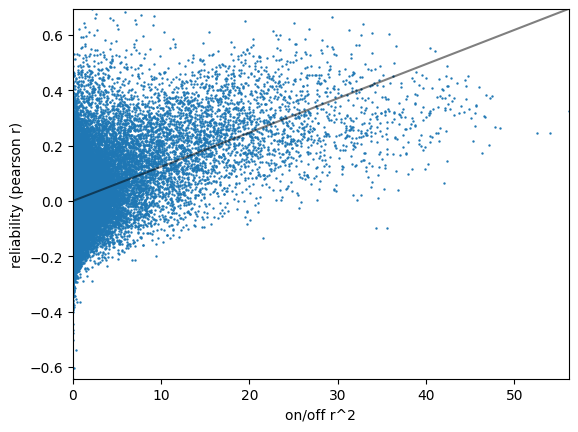

In [33]:
# scatterplot of r^2 threshold vs reliability
print(on_off['onoffR2'].shape, rels.shape)
x = on_off['onoffR2']
y = rels

r2_thresh = 0
mask = np.where(x>=r2_thresh)
x_thresh = x[mask]; y_thresh = y[mask]

plt.scatter(x_thresh, y_thresh, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.plot(np.unique(x_thresh), np.poly1d(np.polyfit(x_thresh, y_thresh, 1))(np.unique(x_thresh)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

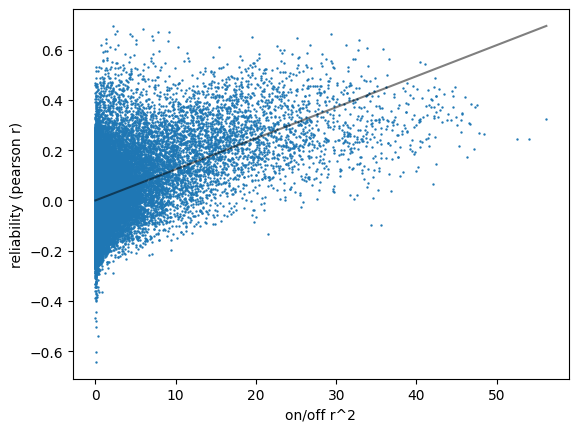

In [34]:
plt.scatter(x, y, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

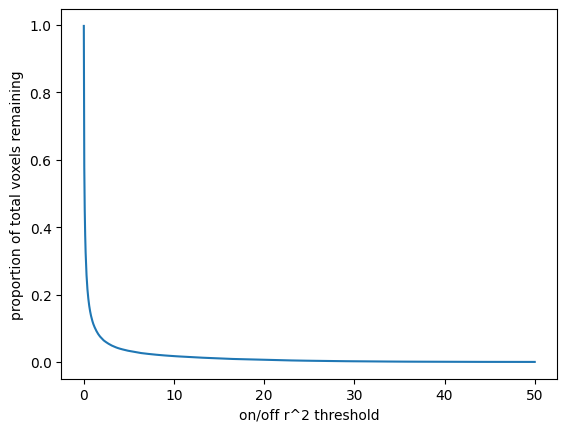

In [35]:
# at each onoff r2 threshold, what percentage of total voxels remain? 
r2_thresholds = np.linspace(0,50,1000)
# print('r2 thresh: proportion of voxels left (raw #)')
all_prop = []
for thresh in r2_thresholds:
    mask = np.where(x>=thresh)
    prop = x[mask].shape[0]/x.shape[0]
    # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
    all_prop.append(prop)
plt.plot(r2_thresholds, all_prop)
plt.xlabel('on/off r^2 threshold')
plt.ylabel('proportion of total voxels remaining')
plt.show()

In [36]:
baseline = np.sum(y>0.2)
print(f'baseline: {baseline} voxels with reliability > 0.2')
for r2 in np.arange(0,20,.5):
    num = np.sum(y[np.where(x>r2)]>0.2)
    print(f'{num} voxels ({(num/baseline):.2%}) with r^2 > {r2:.2f}')
    

baseline: 5174 voxels with reliability > 0.2
5169 voxels (99.90%) with r^2 > 0.00
3779 voxels (73.04%) with r^2 > 0.50
3484 voxels (67.34%) with r^2 > 1.00
3266 voxels (63.12%) with r^2 > 1.50
3093 voxels (59.78%) with r^2 > 2.00
2955 voxels (57.11%) with r^2 > 2.50
2833 voxels (54.75%) with r^2 > 3.00
2709 voxels (52.36%) with r^2 > 3.50
2612 voxels (50.48%) with r^2 > 4.00
2524 voxels (48.78%) with r^2 > 4.50
2439 voxels (47.14%) with r^2 > 5.00
2351 voxels (45.44%) with r^2 > 5.50
2267 voxels (43.82%) with r^2 > 6.00
2191 voxels (42.35%) with r^2 > 6.50
2120 voxels (40.97%) with r^2 > 7.00
2054 voxels (39.70%) with r^2 > 7.50
1994 voxels (38.54%) with r^2 > 8.00
1940 voxels (37.50%) with r^2 > 8.50
1874 voxels (36.22%) with r^2 > 9.00
1829 voxels (35.35%) with r^2 > 9.50
1758 voxels (33.98%) with r^2 > 10.00
1704 voxels (32.93%) with r^2 > 10.50
1645 voxels (31.79%) with r^2 > 11.00
1593 voxels (30.79%) with r^2 > 11.50
1550 voxels (29.96%) with r^2 > 12.00
1486 voxels (28.72%) with

85732 voxels with reliability > 0.0 without on/off r^2 threshold
24455 voxels with reliability > 0.1 without on/off r^2 threshold
5174 voxels with reliability > 0.2 without on/off r^2 threshold
1781 voxels with reliability > 0.3 without on/off r^2 threshold
669 voxels with reliability > 0.4 without on/off r^2 threshold


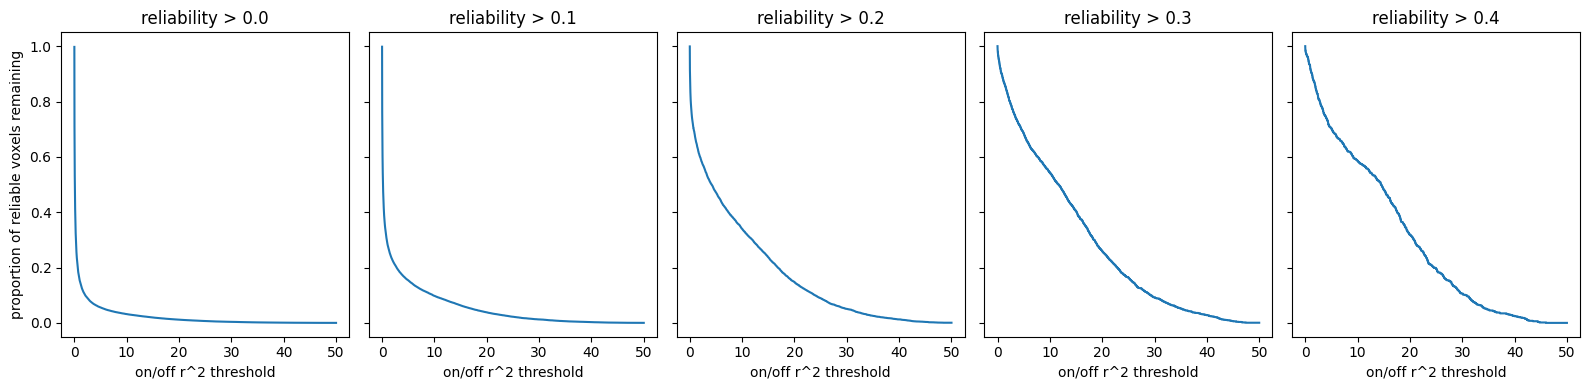

In [37]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,100000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_prop = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        # print(num)
        prop = num/baseline
        # print(f'{prop:.2%} voxels with reliability > {rel_thresh} at on/off r^2 > {r2_thresh}')
        # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
        all_prop.append(prop)
    ax[i].plot(r2_thresholds, all_prop)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('proportion of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()

85732 voxels with reliability > 0.0 without on/off r^2 threshold
24455 voxels with reliability > 0.1 without on/off r^2 threshold
5174 voxels with reliability > 0.2 without on/off r^2 threshold
1781 voxels with reliability > 0.3 without on/off r^2 threshold
669 voxels with reliability > 0.4 without on/off r^2 threshold


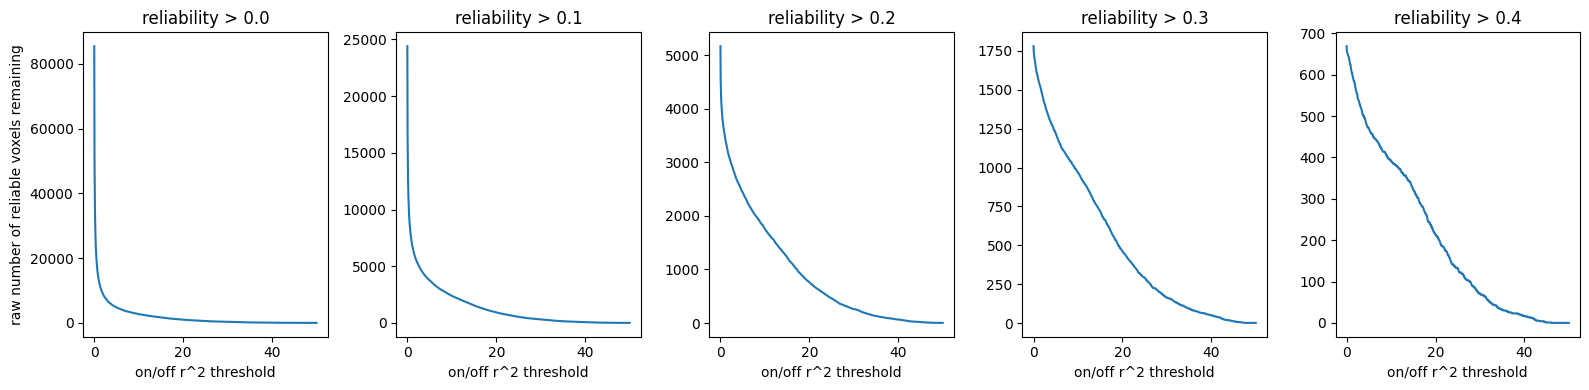

In [38]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,1000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=False)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_num = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        all_num.append(num)
    ax[i].plot(r2_thresholds, all_num)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('raw number of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()